# Vector Time series forecasting of Industrial production: Electric and Gas Utilities using GDP and Temperature over time


## Introduction

In this project, I am going to do the forecasting on industrial production data of electric and gas utilities. I will be using the statistical models for time series analysis. Testing the data against the multiple models. In addition, I will be doing the analysis on seasonality and stationarity of the data as well. Moreover, I will visualize the result. At the end, I will use the best model parameters to do forecasting for the future values.
The type of data science task that will be involved in this project is a predictive analysis. I will be using Vector Autoregressive model for forecasting. Using the past values, GDP and temperature I will predict the future industrial production. The data science pipeline includes loading the data, check for seasonality, stationarity, and visualization of the data. Ending with forecasting the new values for industrial production.

## Importing Libraries

In [1]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


# From Statsmodels  api
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
warnings.filterwarnings("ignore")



## Data description

### I have used 3 datasets. These datasets have monthly frequency and different range

- Industrial Production(1939 to 2021)
- Average Temperature (1895 to 2021)
- Normalized GDP of USA (1960 to 2021)

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories. The link for the data is shown in link (a)
The temperature data is average temperature monthly from 1895 to 2021 downloaded from link (b)
The GDP data is also monthly adjusted. I have taken two source for gdp data shown in link (c) and (d) 
- a.	https://fred.stlouisfed.org/series/IPG2211A2N

- b.	https://www.ncdc.noaa.gov/cag/national/time-series/110/tavg/all/6/1895-2021?base_prd=true&begbaseyear=1901&endbaseyear=2000
- c.	https://ycharts.com/indicators/us_monthly_gdp
- d.	https://fred.stlouisfed.org/series/USALORSGPNOSTSAM



## Reading the data

In [2]:
df_ip = pd.read_csv("IPG2211A2N.csv")

### Changing the date column into datetime type

In [3]:
df_ip['Date'] = df_ip['DATE'].astype('datetime64[ns]')
df_ip.drop(["DATE"], axis = 1, inplace = True)
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 2 columns):
IPG2211A2N    989 non-null float64
Date          989 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.6 KB


In [4]:
df_ip

,IPG2211A2N,Date
0,3.3298,1939-01-01
1,3.3552,1939-02-01
2,3.4315,1939-03-01
3,3.4569,1939-04-01
4,3.4569,1939-05-01
...,...,...
984,117.6260,2021-01-01
985,115.3512,2021-02-01
986,98.4874,2021-03-01
987,86.6986,2021-04-01


### Reading the temperature data and changing its date column as previous

In [5]:
df_temp = pd.read_csv("110-tavg-all-6-1895-2021.csv", skiprows = 4)
df_temp['Date'] = df_temp['Date'].astype('str')
for i in range(len(df_temp["Date"])):
    df_temp["Date"][i] =  df_temp["Date"][i][:4]+"-"+df_temp["Date"][i][4:]+"-01"
df_temp['Date'] = df_temp['Date'].astype('datetime64[ns]')

In [6]:
df_temp

,Date,Value,Anomaly
0,1895-01-01,26.69,-3.43
1,1895-02-01,26.60,-7.22
2,1895-03-01,39.97,-1.53
3,1895-04-01,52.90,1.85
4,1895-05-01,59.94,-0.26
...,...,...,...
1513,2021-02-01,30.58,-3.24
1514,2021-03-01,45.54,4.04
1515,2021-04-01,51.87,0.82
1516,2021-05-01,60.37,0.17


In [7]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 3 columns):
Date       1518 non-null datetime64[ns]
Value      1518 non-null float64
Anomaly    1518 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 35.7 KB


### USA GDP (Normalized)

In [8]:
df_gdp = pd.read_csv("USALORSGPNOSTSAM.csv")

### Changing the date column into datetime type

In [9]:
df_gdp['Date'] = df_gdp['DATE'].astype('datetime64[ns]')
df_gdp.drop(["DATE"], axis = 1, inplace = True)

In [10]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 2 columns):
USALORSGPNOSTSAM    734 non-null float64
Date                734 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.6 KB


In [11]:
df_gdp

,USALORSGPNOSTSAM,Date
0,101.003413,1960-01-01
1,101.013278,1960-02-01
2,100.939606,1960-03-01
3,100.784798,1960-04-01
4,100.567239,1960-05-01
...,...,...
729,96.080467,2020-10-01
730,96.202415,2020-11-01
731,96.453963,2020-12-01
732,96.704426,2021-01-01


## Merging all three dataset

In [12]:
dfinal1 = df_gdp.merge(df_temp, on="Date", how = 'outer')
dfinal = dfinal1.merge(df_ip, on = "Date", how = "outer")

In [13]:
dfinal = dfinal.dropna(axis = 0)
dfinal = dfinal.drop(["Anomaly"], axis = 1).set_index(dfinal.Date)
dfinal.drop(["Date"], axis = 1, inplace = True)
dfinal.columns = ["Normalized_GDP", "temp", "IP"]

In [14]:
dfinal

,Normalized_GDP,temp,IP
Date,,,
1960-01-01,101.003413,29.46,21.4022
1960-02-01,101.013278,30.52,21.0972
1960-03-01,100.939606,35.91,21.1988
1960-04-01,100.784798,52.59,20.4871
1960-05-01,100.567239,59.31,19.8771
...,...,...,...
2020-10-01,96.080467,54.28,91.1444
2020-11-01,96.202415,46.33,92.8277
2020-12-01,96.453963,35.73,112.7814


## Plotting the data

In [15]:
x1 = dfinal.index
y1 = dfinal.Normalized_GDP
y2 = dfinal.temp
y3 = dfinal.IP

In [16]:
def plott(x1, y1, y2, y3):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (16, 8))
    ax1.plot(x1, y1, label = "P1", c = "gray")
    ax1.set_ylabel("Normalized_GDP")

    ax2.plot(x1, y2, label = "P2", c = "gray")
    ax2.set_ylabel("temp")

    ax3.plot(x1, y3, label = "P3", c = "gray")
    ax3.set_xlabel("time")
    ax3.set_ylabel("IP")
    plt.show()

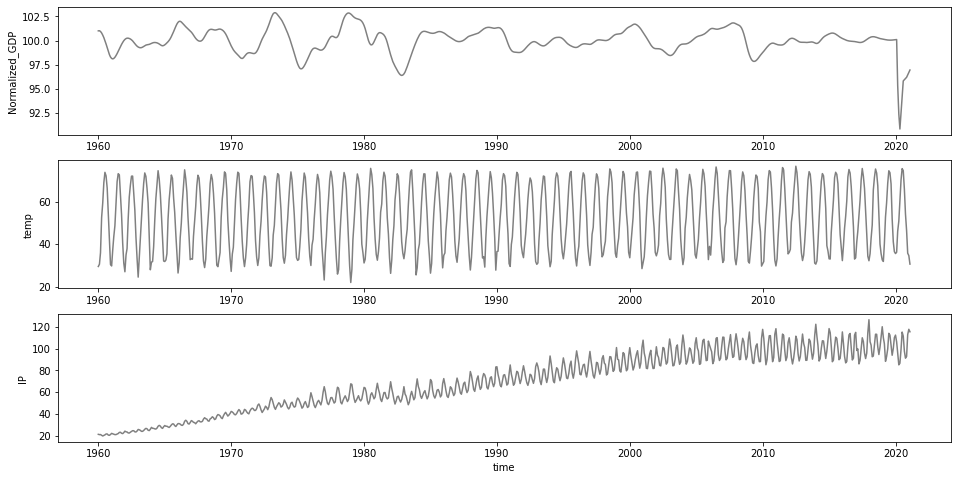

In [17]:
plott(x1, y1, y2, y3)



### Observation
 - The GDP falls down after the Covid-19 shown in the data.
 - The seasonality in the temp data can be seen in the graph. 
 - Industrial Production rises continuously through the years.

### Calculating the rolling mean and standard deviation for a window of 12 observations(an year)



In [18]:
rolmean=dfinal.rolling(window=12).mean()
rolstd=dfinal.rolling(window=12).std()

In [19]:
def plott(x1, y1, y2, y3):
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (16, 8))
    ax1.plot(x1, y1, label = "P1", c = "gray")
    ax1.set_ylabel("Normalized_GDP")

    ax2.plot(x1, y2, label = "P2", c = "gray")
    ax2.set_ylabel("temp")

    ax3.plot(x1, y3, label = "P3", c = "gray")
    ax3.set_xlabel("time")
    ax3.set_ylabel("IP")
    plt.show()
    

In [20]:
rolmean

,Normalized_GDP,temp,IP
Date,,,
1960-01-01,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN
1960-03-01,NaN,NaN,NaN
1960-04-01,NaN,NaN,NaN
1960-05-01,NaN,NaN,NaN
...,...,...,...
2020-10-01,96.125017,53.996667,100.828858
2020-11-01,95.803471,54.431667,100.228917
2020-12-01,95.501721,54.373333,100.462442


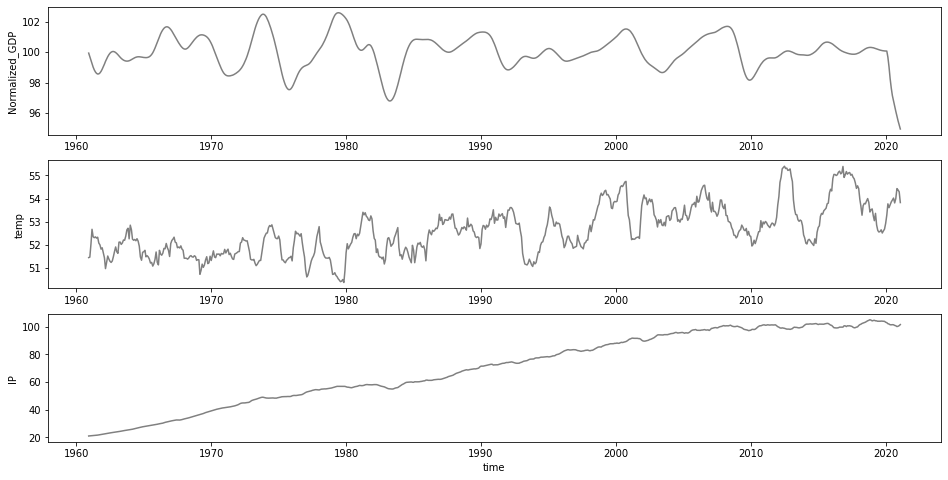

In [21]:
plott(x1,  rolmean.Normalized_GDP, rolmean.temp, rolmean.IP)

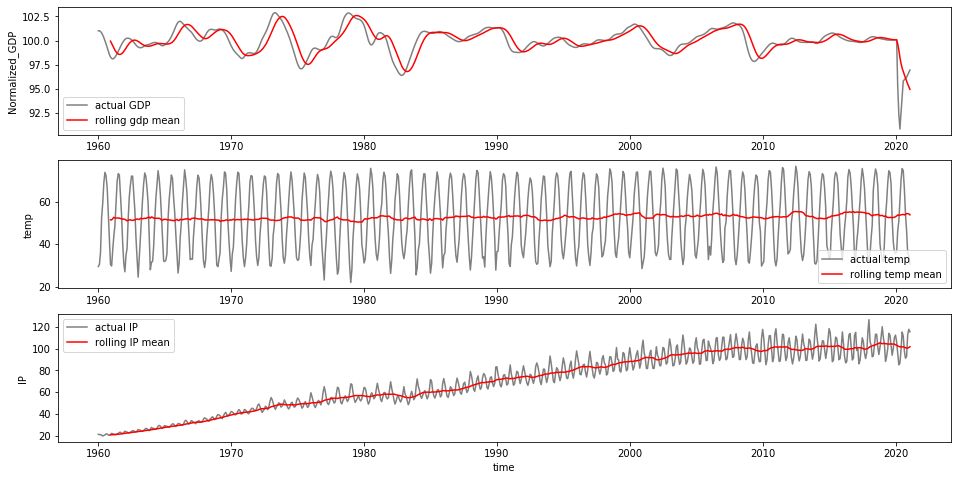

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (16, 8))
ax1.plot(x1, y1, label = "actual GDP", c = "gray", )
ax1.set_ylabel("Normalized_GDP")
ax1.plot(x1, rolmean.Normalized_GDP, c = "r", label = "rolling gdp mean")
ax1.legend()

ax2.plot(x1, y2, label = "actual temp", c = "gray")
ax2.set_ylabel("temp")
ax2.plot(x1, rolmean.temp, c ="r", label = "rolling temp mean")
ax2.legend()

ax3.plot(x1, y3, label = "actual IP", c = "gray")
ax3.plot(x1, rolmean.IP, c = "r", label = "rolling IP mean")
ax3.set_xlabel("time")
ax3.set_ylabel("IP")
plt.legend()
plt.show()

### Splitting the data into train and test
- 1960 to Jan 2014 as training
- Remaining form testing

In [23]:
df_train = dfinal.loc[:'2014-01-01']
df_test = dfinal.loc['2014-02-01' :]
print(df_train)
print(df_test)

            Normalized_GDP   temp        IP
Date                                       
1960-01-01      101.003413  29.46   21.4022
1960-02-01      101.013278  30.52   21.0972
1960-03-01      100.939606  35.91   21.1988
1960-04-01      100.784798  52.59   20.4871
1960-05-01      100.567239  59.31   19.8771
...                    ...    ...       ...
2013-09-01       99.855416  66.96   97.7857
2013-10-01       99.845404  53.44   90.2503
2013-11-01       99.811351  41.61   95.5273
2013-12-01       99.759294  31.06  111.6866
2014-01-01       99.712868  30.56  122.2387

[649 rows x 3 columns]
            Normalized_GDP   temp        IP
Date                                       
2014-02-01       99.700481  32.13  111.0717
2014-03-01       99.742103  40.51  102.9346
2014-04-01       99.833540  51.69   88.5292
2014-05-01       99.958549  61.27   90.5658
2014-06-01      100.097131  69.58  100.2190
...                    ...    ...       ...
2020-10-01       96.080467  54.28   91.1444
2020-11-

## Augmented Dickey-Fuller Test (ADF Test)

#### For every column(series)

In [24]:
def adfuller_test(df_train, col_name):
    
    print('Dickey-Fuller Test: ')
    adftest = adfuller(df_train[col_name])
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print(adfoutput)

#### For temperature series 



In [25]:
adfuller_test(df_train, "temp")

Dickey-Fuller Test: 
Test Statistic           -4.393013
p-value                   0.000305
Lags Used                16.000000
No. of Observations     632.000000
Critical Value (1%)      -3.440739
Critical Value (5%)      -2.866124
Critical Value (10%)     -2.569211
dtype: float64


From the above test, we can see that the **p-value = 0.000305 i.e. < 0.05** (For 95% confidence intervals) therefore, **we can reject the null hypothesis.**  Hence, **we can confirm that the series is stationary.**

In [26]:
adfuller_test(df_train, "Normalized_GDP")

Dickey-Fuller Test: 
Test Statistic         -6.219192e+00
p-value                 5.274086e-08
Lags Used               2.000000e+01
No. of Observations     6.280000e+02
Critical Value (1%)    -3.440806e+00
Critical Value (5%)    -2.866153e+00
Critical Value (10%)   -2.569227e+00
dtype: float64


From the above test, we can see that the **p-value = 5.274086e-08 i.e. < 0.05** (For 95% confidence intervals) therefore, **we can reject the null hypothesis.**  Hence, **we can confirm that the series is stationary.**

In [27]:
adfuller_test(df_train, "IP")

Dickey-Fuller Test: 
Test Statistic           -1.425215
p-value                   0.570130
Lags Used                15.000000
No. of Observations     633.000000
Critical Value (1%)      -3.440723
Critical Value (5%)      -2.866117
Critical Value (10%)     -2.569207
dtype: float64


From the above test, we can see that the **p-value = 0.57 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**  Hence, **we can confirm that the series is non-stationary.**

# Seasonal decomposition of the data 
#### For every column 
- Seasonal decomposition is decomposition the data into multiple individual aspects(trend, seasonal residual)

In [28]:
def seasonal_decomposition(df_train, col_name):
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomp = seasonal_decompose(df_train[col_name])

    trend = decomp.trend
    seasonal = decomp.seasonal
    residual = decomp.resid

    plt.figure(figsize=(15,10))
    plt.subplot(411)
    plt.plot(df_train[col_name], label='Actual', marker='.')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend', marker='.')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', marker='.')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', marker='.')
    plt.legend(loc='upper left')
    plt.tight_layout()

### Seasonal decomposition of temperature



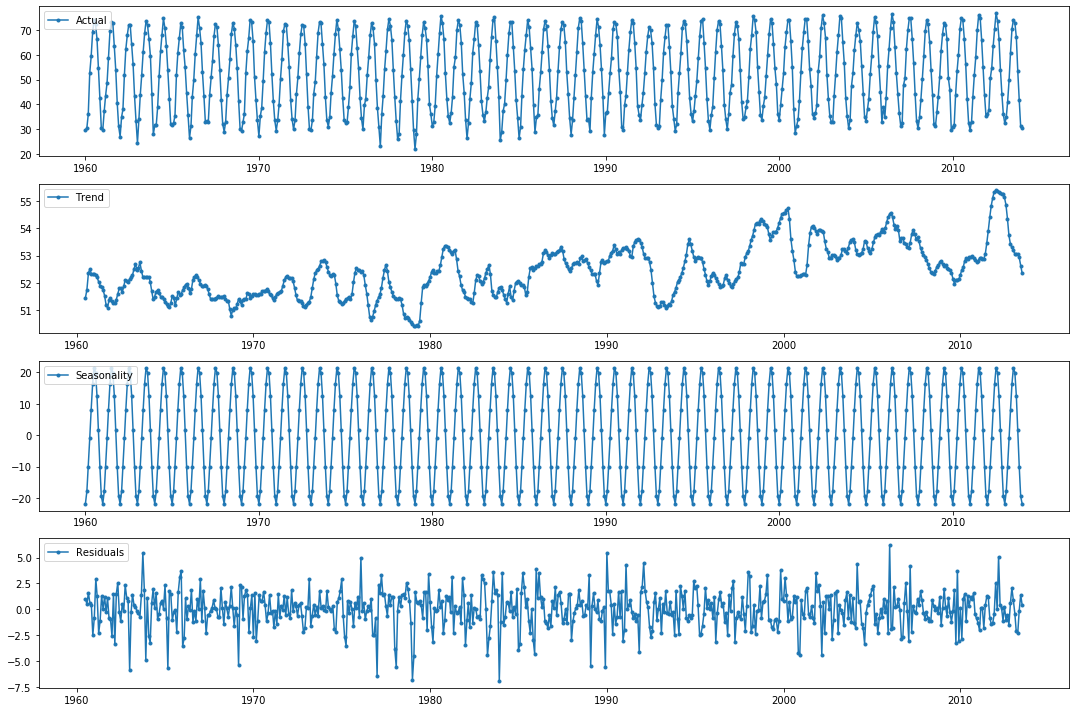

In [29]:
seasonal_decomposition(df_train, "temp")

- We can see that there are significant **seasonality and residuals components** in the series
- although the trend is is not quite significant
- The plot for seasonality shows that **temperature rises in the middle of the year**

### Seasonal decomposition of Normalized_GDP



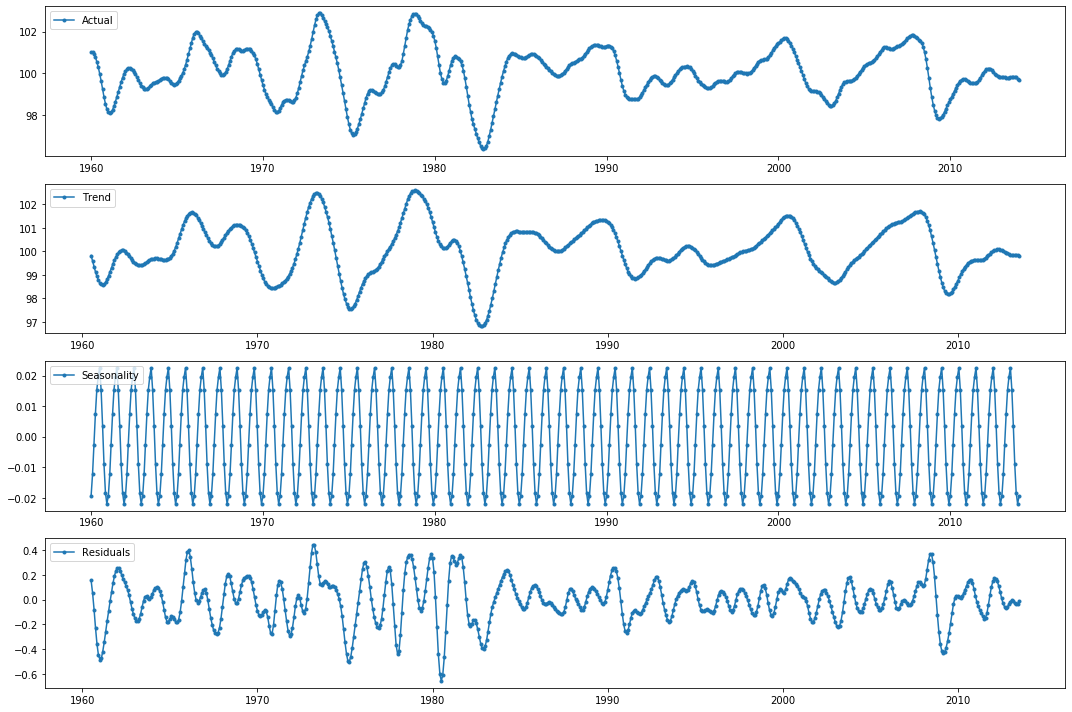

In [30]:
seasonal_decomposition(df_train, "Normalized_GDP")

- We can see that there are significant **seasonality and residuals components** in the series
- Although the trend is is not quite significant

### Seasonal decomposition of Industrial production

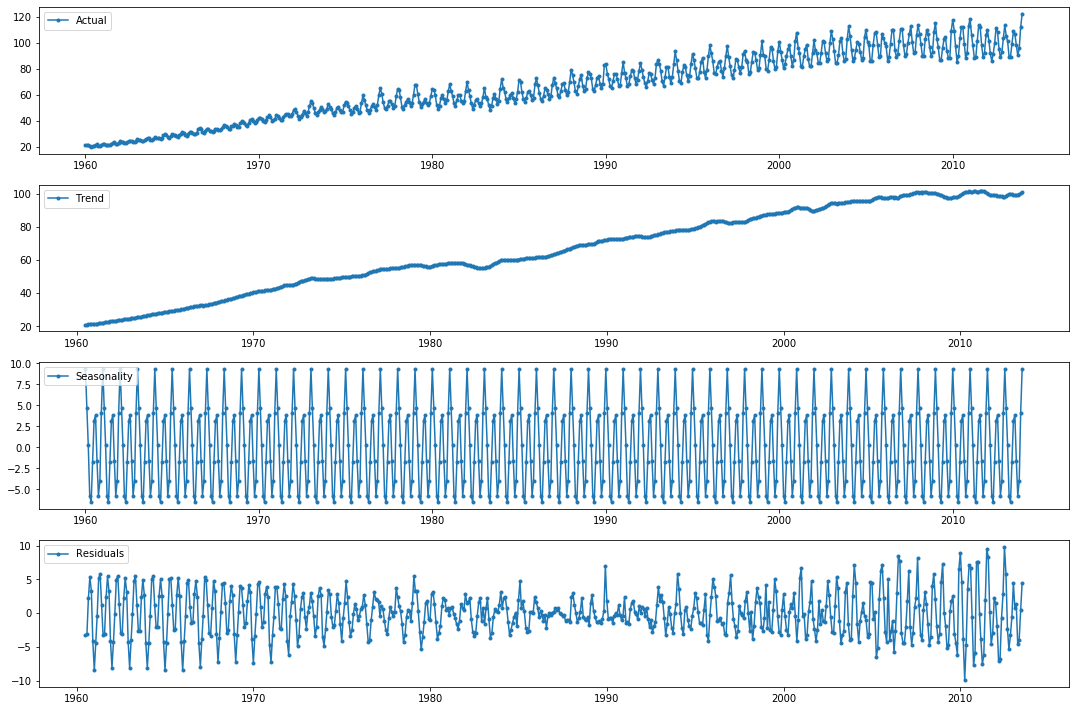

In [31]:
seasonal_decomposition(df_train, "IP")

- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **industrial production spike in December, January, and June.**

## Making the IP(Industrial Production) series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

I am going to  use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

### Visualize the rolling mean and standard deviation after using log transformation



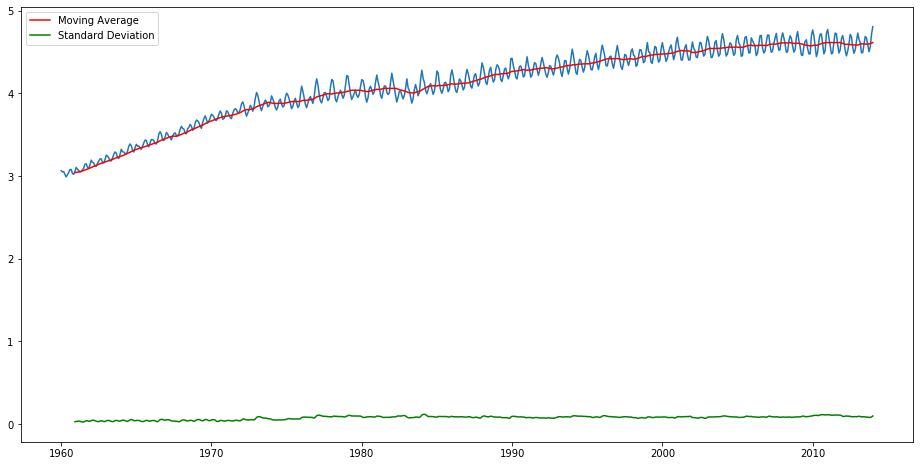

In [32]:
plt.figure(figsize=(16,8))
df_log_IP = np.log(df_train["IP"])
MAvg = df_log_IP.rolling(window=12).mean()

MStd = df_log_IP.rolling(window=12).std()
plt.plot(df_log_IP)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

In [33]:
adfuller_test(pd.DataFrame(df_log_IP, columns = ["IP"]), "IP")

Dickey-Fuller Test: 
Test Statistic           -4.821068
p-value                   0.000050
Lags Used                15.000000
No. of Observations     633.000000
Critical Value (1%)      -3.440723
Critical Value (5%)      -2.866117
Critical Value (10%)     -2.569207
dtype: float64


Now we can see that the **p-value = 0.000050 i.e. < 0.05** (For 95% confidence intervals) Now, **we can confirm that the series is stationary.**

In [34]:
df_train["log_IP"] = df_log_IP

### Using log transformed data for training



In [35]:
df_train_st = df_train[["Normalized_GDP", "temp", "log_IP"]]

### Selecting parameter for var model

In [36]:
model = VAR(df_train_st)

In [37]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,4.019,4.041,55.67,4.028
1,-4.937,-4.852,0.007177,-4.904
2,-9.749,-9.601,5.833e-05,-9.692
3,-12.73,-12.52,2.955e-06,-12.65
4,-14.80,-14.52,3.752e-07,-14.69
5,-15.79,-15.45,1.393e-07,-15.65
6,-16.00,-15.60,1.128e-07,-15.84
7,-16.04,-15.58,1.079e-07,-15.86
8,-16.16,-15.63,9.584e-08,-15.95
9,-16.22,-15.62,9.053e-08,-15.99


#### The AIC value drops fastly at lag 4 and then drops slowly so i will you use lag = 13

#### it will be a good(Optimum) combination of model complexity and getting good results

## Fitting the model

In [38]:
fitted_model = model.fit(13)
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Aug, 2021
Time:                     03:25:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -16.0964
Nobs:                     636.000    HQIC:                  -16.6106
Log likelihood:           2798.63    FPE:                4.41138e-08
AIC:                     -16.9370    Det(Omega_mle):     3.67371e-08
--------------------------------------------------------------------
Results for equation Normalized_GDP
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.113402         0.021924            5.173           0.000
L1.Normalized_GDP          4.505997         0.040913          110.136           0.000
L1.temp                   -0.00

## Checking the lag of fitted model



In [39]:
lag_ = fitted_model.k_ar
print(lag_)

13


## Getting the input ready for testing



In [40]:
f_input = df_train_st.values[-lag_:]
f_input

array([[99.82234424, 32.25      ,  4.72957922],
       [99.82268302, 34.77      ,  4.65089757],
       [99.81551368, 40.91      ,  4.61524526],
       [99.80513076, 49.68      ,  4.49058055],
       [99.80063929, 60.85      ,  4.49160387],
       [99.80888717, 70.39      ,  4.59585191],
       [99.82686832, 74.21      ,  4.68782701],
       [99.84597654, 72.99      ,  4.67016829],
       [99.85541585, 66.96      ,  4.58277835],
       [99.84540362, 53.44      ,  4.50258692],
       [99.81135131, 41.61      ,  4.55941207],
       [99.75929371, 31.06      ,  4.71569673],
       [99.71286756, 30.56      ,  4.80597569]])

### Forecasting the future steps



In [41]:
prediction = fitted_model.forecast(f_input, steps=len(df_test))

### Creating a dataframe of predicted values

In [42]:
prediction_df = pd.DataFrame(prediction, columns = ["Normalized_GDP", "temp", "log_IP"])

In [43]:
prediction_df

,Normalized_GDP,temp,log_IP
0,99.701887,34.505324,4.724262
1,99.745969,41.660008,4.638199
2,99.843914,51.742117,4.514536
3,99.978706,61.225484,4.509339
4,100.127128,69.824636,4.614954
...,...,...,...
80,100.092839,54.584266,4.554125
81,100.081865,42.501751,4.610295
82,100.072347,34.400605,4.735496
83,100.065770,32.442107,4.810635


### Inverse Log transformation

In [44]:
prediction_df["IP"] = np.exp(prediction_df["log_IP"])

### Selecting the final predicted dataframe

In [45]:
final_pred_df = prediction_df[["Normalized_GDP", "temp", "IP"]]

In [46]:
final_pred_df

,Normalized_GDP,temp,IP
0,99.701887,34.505324,112.647300
1,99.745969,41.660008,103.358061
2,99.843914,51.742117,91.335152
3,99.978706,61.225484,90.861726
4,100.127128,69.824636,100.983233
...,...,...,...
80,100.092839,54.584266,95.023594
81,100.081865,42.501751,100.513833
82,100.072347,34.400605,113.920003
83,100.065770,32.442107,122.809628


In [47]:
for col in ["Normalized_GDP", "temp", "IP"]:
    print(f"RMSE Error for feature(column) {col} = {rmse(df_test[col], final_pred_df[col])}")

RMSE Error for feature(column) Normalized_GDP = 2.070333071720287
RMSE Error for feature(column) temp = 2.2703196774665795
RMSE Error for feature(column) IP = 4.703670218955772


### R2 SCORE



In [48]:
from sklearn.metrics import r2_score
for col in ["temp", "IP"]:
    print(f"R squred Error for feature(column) {col} = {r2_score(df_test[col], final_pred_df[col])}")

R squred Error for feature(column) temp = 0.9771142853329259
R squred Error for feature(column) IP = 0.768248602063864


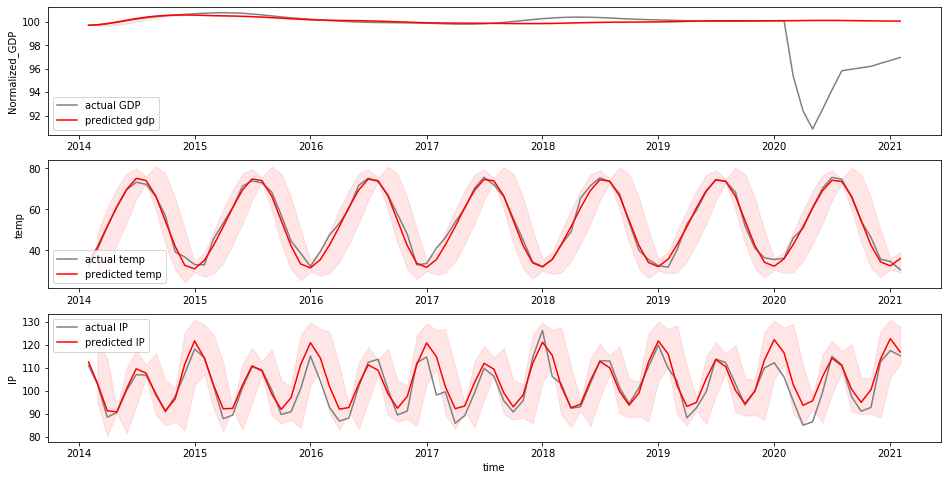

In [49]:
x2 = df_test.index
smooth_path    = final_pred_df.rolling(2).mean()
path_deviation = 2* final_pred_df.rolling(2).std()
under_line     = smooth_path-path_deviation
over_line    = smooth_path+path_deviation


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (16, 8))
ax1.plot(x2, df_test.Normalized_GDP, label = "actual GDP", c = "gray", )
ax1.set_ylabel("Normalized_GDP")
ax1.plot(x2, final_pred_df.Normalized_GDP, c = "r", label = "predicted gdp")
ax1.fill_between(x2, under_line.Normalized_GDP, over_line.Normalized_GDP, color='r', alpha=.1)
ax1.legend()

ax2.plot(x2, df_test.temp, label = "actual temp", c = "gray")
ax2.set_ylabel("temp")
ax2.plot(x2, final_pred_df.temp, c ="r", label = "predicted temp")
ax2.fill_between(x2, under_line.temp, over_line.temp, color='r', alpha=.1)
ax2.legend()

ax3.plot(x2, df_test.IP, label = "actual IP", c = "gray")
ax3.plot(x2, final_pred_df.IP, c = "r", label = "predicted IP")
ax3.fill_between(x2, under_line.IP, over_line.IP, color='r', alpha=.1)
ax3.set_xlabel("time")
ax3.set_ylabel("IP")

plt.legend()
plt.show()

## Result


On the test data, the model is able to correctly predict. Not only the short term trend of the industrial production. As we can see that the red line appears to be close to the actual values (Gray), and they both have a close run and the test predictions are strongly able to identify the volatile variations in the industrial production from 2014 to 2021

**As observed earlier, most of the predicted values on the training data are very close to the actual values**
**The RMSE error for each column**
- RMSE Error for feature(column) Normalized_GDP = 2.0703330714051513
- RMSE Error for feature(column) temp = 2.2703196775231493
- RMSE Error for feature(column) IP = 4.703670218395221
    
These values are areally small considering the range of values

**The R squred error is realy good as well as they are very close to 1. Find the values below**
- R squred Error for feature(column) temp = 0.9771142853317853
- R squred Error for feature(column) IP = 0.7682486021191012

## References
- https://www.statsmodels.org/dev/vector_ar.html
- https://fred.stlouisfed.org/series/USALORSGPNOSTSAM
- https://www.ncdc.noaa.gov/cag/national/time-series/110/tavg/all/6/1895-2021?base_prd=true&begbaseyear=1901&endbaseyear=2000
- https://fred.stlouisfed.org/series/IPG2211A2N
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html
- https://www.edureka.co/community/72357/what-is-the-inverse-operation-of-np-log-and-np-diff
- https://otexts.com/fpp2/accuracy.html  

